In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from util import calculate_metrics
import time
from data import prepare_data, prepare_sequences

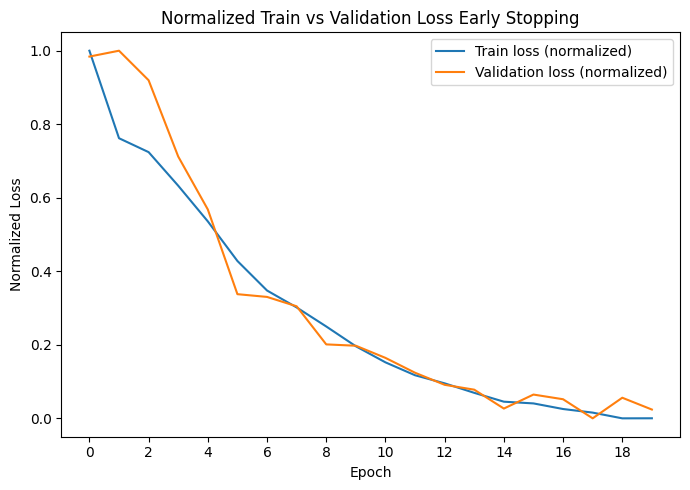

In [13]:
df = pd.read_csv('logs/training_logs.csv')

df['val_loss'] = df['val_loss'].astype(float)
df['train_loss'] = df['train_loss'].astype(float)

# Min-max normalization
train_min = df['train_loss'].min()
train_max = df['train_loss'].max()
val_min = df['val_loss'].min()
val_max = df['val_loss'].max()

df['train_loss_norm'] = (df['train_loss'] - train_min) / (train_max - train_min)
df['val_loss_norm'] = (df['val_loss'] - val_min) / (val_max - val_min)

epochs = range(len(df))

plt.figure(figsize=(7, 5))
plt.plot(epochs, df['train_loss_norm'].values, label="Train loss (normalized)")
plt.plot(epochs, df['val_loss_norm'].values, label="Validation loss (normalized)")
plt.title("Normalized Train vs Validation Loss Early Stopping")
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.xticks(range(0, len(df), 2))  # ticks every 2 epochs
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
df = prepare_data("data/mm79158.csv")
input_window = 14 * 24
forecast_horizon = 1

X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_sequences(
    df, input_window=input_window, forecast_horizon=forecast_horizon,
    val_ratio=0.1, test_ratio=0.3
)

In [37]:
import tensorflow as tf

model_path = 'models/model_336_1.h5'
model = tf.keras.models.load_model(model_path)

In [38]:
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

results = calculate_metrics(y_test, y_pred, end_time - start_time, 'st')
results_df = pd.DataFrame([results])


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [39]:
def plot_values(true_vals, pred_vals, label="Model"):
    plt.figure(figsize=(30, 7))
    plt.plot(true_vals, label="True Values", color="blue", linewidth=0.5)
    plt.plot(pred_vals, label=f"Predicted by {label}", color="red", linewidth=0.5)
    plt.title(f"Iterative Forecast: {label}")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

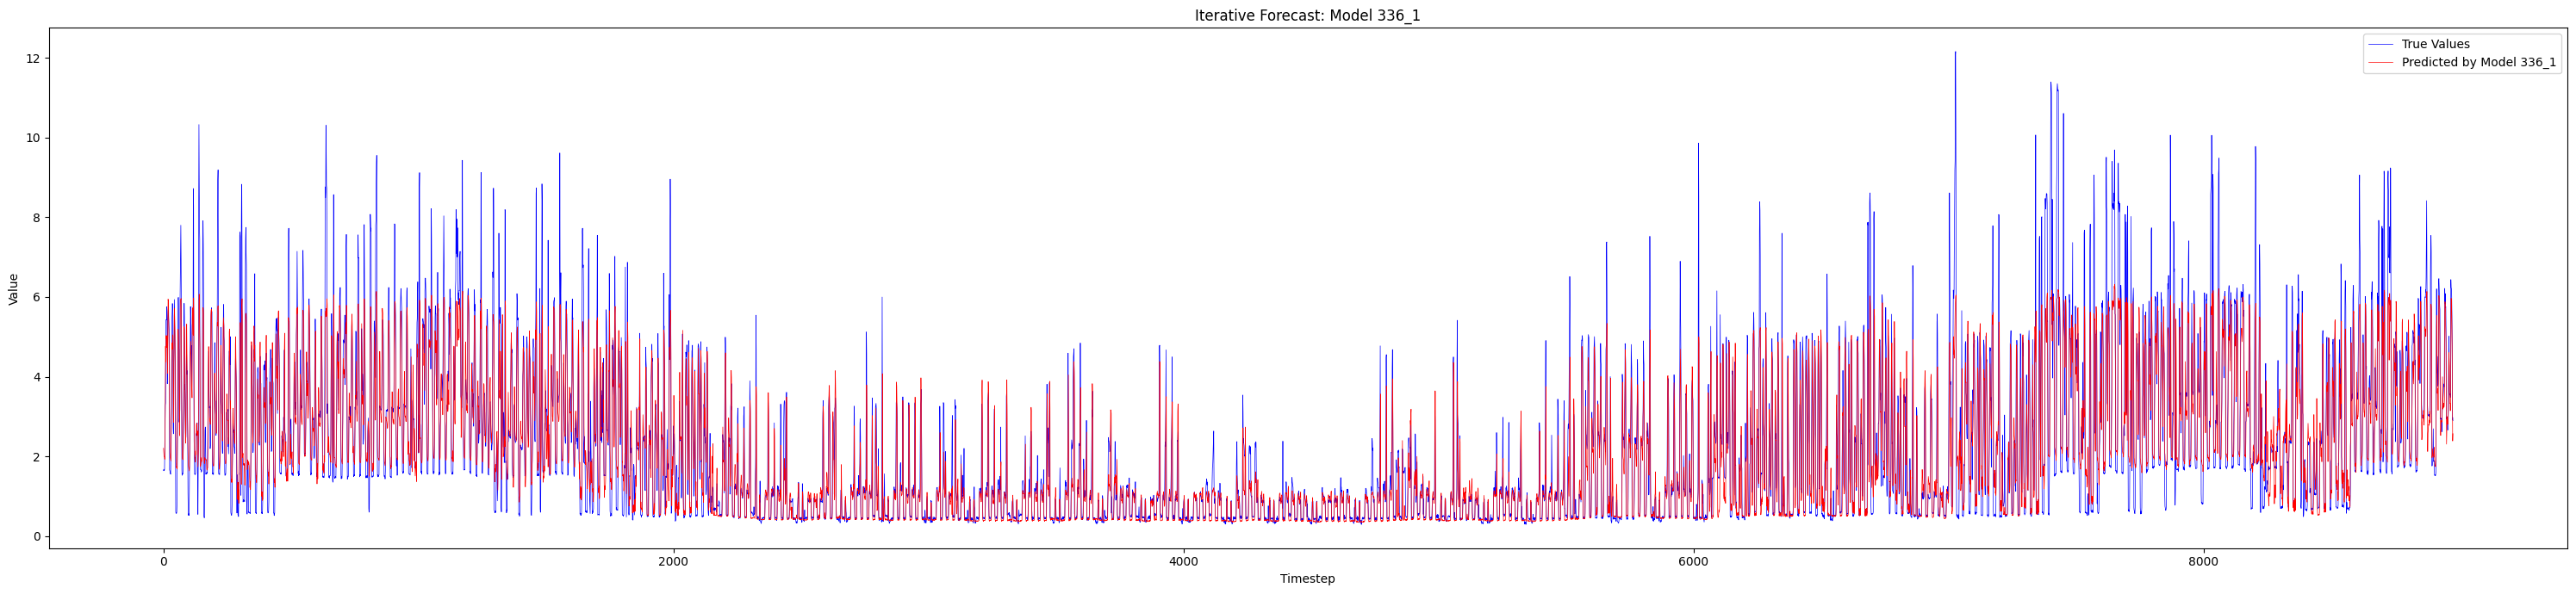

In [40]:
plot_values(y_test, y_pred, 'Model 336_1')

In [42]:
def horizon_rolling_forecast(model, initial_input, X_test, forecast_horizon, input_window, scaler):
    preds = []
    current_input = initial_input.copy()
    total_chunks = len(X_test) // forecast_horizon

    for i in range(total_chunks):
        print(f"🔮 Forecast chunk {i + 1}/{total_chunks}", end='\r', flush=True)

        # Predict next horizon values
        pred = model.predict(current_input, verbose=0)[0]  # shape: (horizon,)
        preds.extend(pred.tolist())

        # Get real input features for next horizon
        x_next_chunk = X_test[i * forecast_horizon: (i + 1) * forecast_horizon]

        # If 3D, take last timestep per horizon step
        if x_next_chunk.ndim == 3:
            x_next_chunk = x_next_chunk[:, -1, :]  # shape: (horizon, features)

        # Exclude target column (assumed to be first column)
        x_next_features = x_next_chunk[:, 1:]  # shape: (horizon, feature_dim - 1)

        # Combine predicted target + real features
        pred_array = np.array(pred).reshape(forecast_horizon, 1)  # shape: (horizon, 1)
        combined = np.concatenate([pred_array, x_next_features], axis=1)  # shape: (horizon, feature_dim)

        # Update current input window
        current_input = np.concatenate([
            current_input.reshape(-1, current_input.shape[-1]),  # shape: (input_window, feature_dim)
            combined
        ], axis=0)

        # Trim to keep only last `input_window` steps and reshape to model input shape
        current_input = current_input[-input_window:].reshape(1, input_window, -1)

    preds = np.array(preds).reshape(-1, 1)
    return scaler.inverse_transform(preds).flatten()


In [43]:
initial_input = X_val[-1:].copy()  # shape: [1, window, 1]
total_steps = len(X_test)

print(f"🔁 Running iterative forecast for model with input_window={input_window}, forecast_horizon={forecast_horizon}")

start_time = time.time()
preds_rescaled = horizon_rolling_forecast(
    model=model,
    initial_input=initial_input,
    X_test=X_test,
    forecast_horizon=forecast_horizon,
    input_window=input_window,
    scaler=scaler
)
end_time = time.time()

preds_flat = preds_rescaled.reshape(-1)
results_df = pd.concat([results_df, pd.DataFrame([calculate_metrics(y_test, preds_flat, end_time - start_time, 'lt')])], axis=0)


🔁 Running iterative forecast for model with input_window=336, forecast_horizon=1


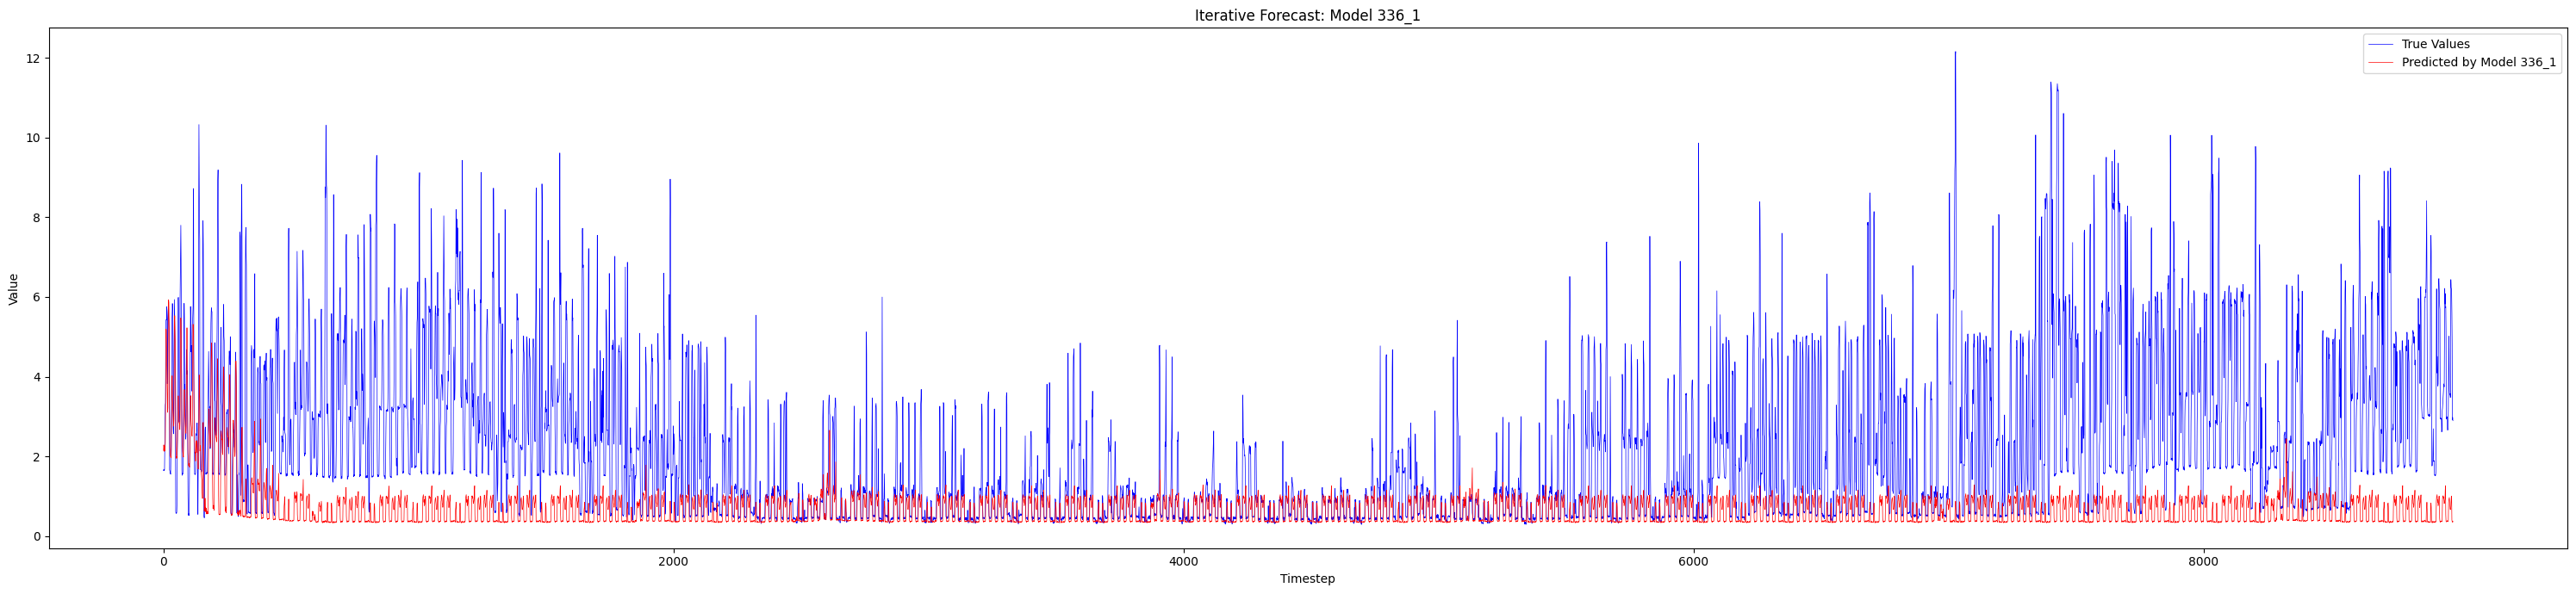

In [44]:
plot_values(y_test, preds_rescaled, 'Model 336_1')

In [47]:
y_test.shape

(8978, 1)

In [48]:
pred_df = pd.DataFrame({
    'y_true': y_test.flatten(),
    'y_st': y_pred.flatten(),
    'y_lt': preds_flat.flatten()
})


In [49]:
results_df.to_csv('logs/prediction_eval.csv', index=False)
pred_df.to_csv('logs/prediction_data.csv', index=False)